# Executive Summary

In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from unidecode import unidecode 
from sklearn.cluster import KMeans
from mpl_toolkits.basemap import Basemap

from math import cos, sin, asin

helper_colors = [
    'tab:red',
    'tab:orange',
    'tab:purple',
    'tab:pink',
    'tab:cyan',
    'tab:grey',
    'tab:olive',
    
    'tab:blue',
    'tab:green',
    'tab:brown',
]

us_df = pd.read_csv(r'us_solution_4.csv')
world_df = pd.read_csv(r'world_solution_4.csv')

all_df = us_df.append(world_df).drop(columns=['cluster', \
           'longitude_mean', 'latitude_mean', 'headline_count', 'distance_2_center'])

diseases_df = pd.read_csv(r'diseases.csv')


In [2]:
def draw_world_map():
    map = Basemap()
    map.drawcoastlines()
    map.drawcountries()
    return map

def draw_point_on_map(map, locations, colors):
    for i in range(len(locations)):
        color = colors[i]
        lat = locations[i][1]
        long = locations[i][0]
        map.scatter([long], [lat], color=color, latlon=True, s=50)

def display_result_layout(titel, df, clusters_prediction_count):
    fig = plt.figure(figsize=(20,14))
    locations = df[['longitude','latitude']].values
       
    plt.title(titel, fontsize=20)

    location_clusters = KMeans(clusters_prediction_count).fit_predict(locations)
    cluster_colors = [helper_colors[cluster] for cluster in location_clusters]

    map = draw_world_map()
        
    draw_point_on_map(map, locations, cluster_colors)
    _ = fig.text(.125, .2, 'figure 1.2', ha='left', fontsize=15)
    plt.show()
        
    return pd.Series(location_clusters)

def great_circle_distance(x1, y1, x2, y2):
    delta_x, delta_y = x2 - x1, y2 - y2
    haversin = sin(delta_x / 2) ** 2 + pd.np.product([cos(x1), cos(x2), sin(delta_y / 2) ** 2])
    return 2 * asin(haversin ** 0.5)

def travel_distance (lat1, lon1, lat2, lon2):
    to_radians =  pd.np.radians([lat1, lon1, lat2, lon2])
    return 3956 * great_circle_distance(*to_radians.tolist())


## 1. Identified Diseases

We could identify one disease, the Zika virus, that dominatated in the provided data, with around about 35%. Not other disease, surpass the 10% base limit. The Top 5 are listed in the figure 1.1

_**Disclaimer:** Nevertheless the diseases with atleast 10 or higher ocurrences should be monitored and/or analysed, since these could be local emerging outbreaks, and we focues on worldwide spreading diseases._

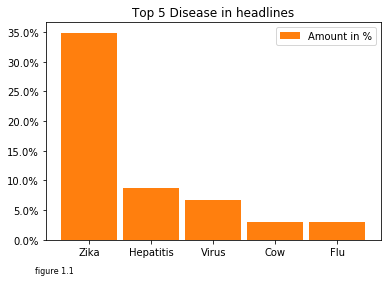

In [3]:
diseases_df['precent'] = round(diseases_df['helper']/650*100,2)

fig = plt.figure()
ax = diseases_df['precent'].head(5).plot.bar(title="Top 5 Disease in headlines", width=.9, color='tab:orange')
ax.legend(['Amount in %'])
ax.yaxis.set_major_formatter( mtick.PercentFormatter())
plt.xticks(pd.np.arange(5), diseases_df["words"], rotation=0)
_ = fig.text(.1, .01, 'figure 1.1', ha='left', fontsize=8)

## 2. The Zika Virus
In our further analysis, we determined the hotspots around the world, where the Zika virus is spreading. As a visual aid please consult the figure 1.2.

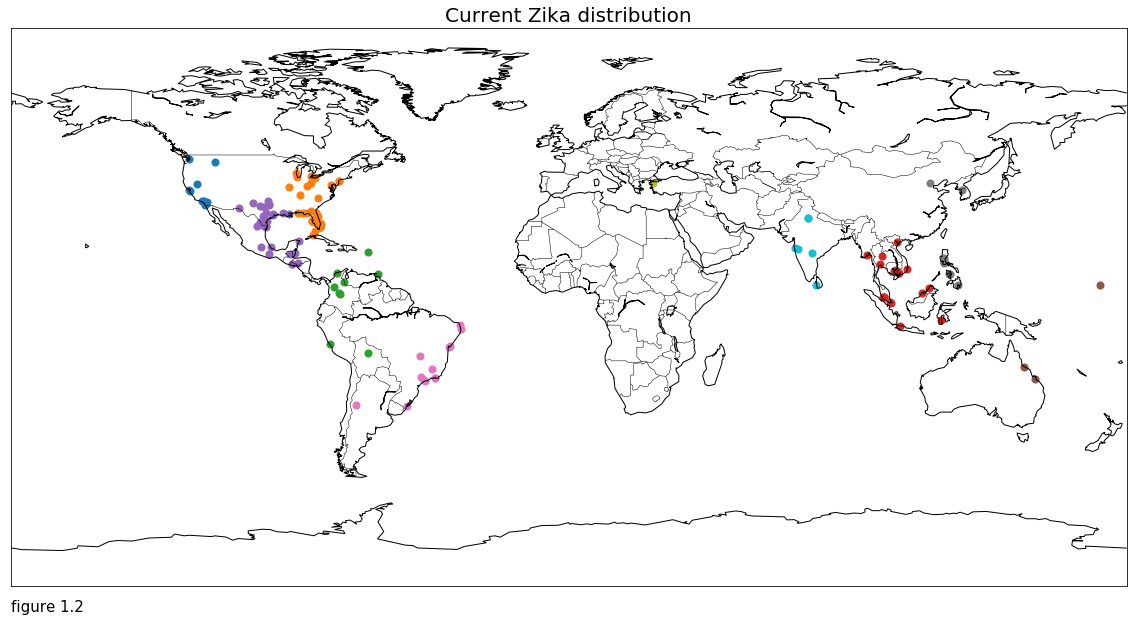

In [4]:
headlines = [line for line in all_df['headline'].values if re.search('Zika', line)]

zika_df = all_df[all_df['headline'].isin(headlines)].copy(deep=True)
zika_df = zika_df.reset_index()

zika_df['clusters'] = display_result_layout('Current Zika distribution', zika_df, 10)

As it can be seen on the map, the Zika Virus seems to has spread over North and South America and in SouthEast Asia.  
  
Europe _(if you don't count Turkey)_, Russia and Afrika seem to be clear, but this could just be due to the small data sample we used.

## 3. The HotSpots
Just to give a overview over the HotSpot, we have created a table with the Top 5 Cities nearest to the outbreak cluster centers.


_**Disclaimer:** Since we expect the cities in the clusters to be close to eachother, we used an aproximation to calculate the center of the clusters._

In [5]:
zika_df = zika_df.dropna(subset=['clusters'])

zika_extended_df = zika_df.groupby(['clusters'])['longitude', 'latitude'].agg(longitude_mean=('longitude', 'mean'), 
                   latitude_mean=('latitude', 'mean'),headline_count=('longitude', 'count'))
zika_last_df = zika_df.copy(deep=True).merge(zika_extended_df, left_on='clusters', right_on='clusters').sort_values(['headline_count'], ascending=False)

zika_last_df['distance_center'] = \
        zika_last_df.apply(lambda row: round( \
            travel_distance(row['latitude'], \
                    row['longitude'],row['latitude_mean'],\
                    row['longitude_mean']), 2), axis=1)

zika_last_df = zika_last_df.groupby('clusters')['clusters', 'countrycode','cities', 'headline_count', 'distance_center'].head(5)
#zika_last_df.sort_values(['clusters', 'headline_count', 'distance_center'], ascending=[True,False, True])[['clusters', 'countrycode', 'cities', 'distance_center']]
zika_last_df['clusters'] = zika_last_df.apply(lambda row: helper_colors[int(row['clusters'])].replace('tab:',''), axis=1)
zika_last_df

,clusters,countrycode,cities,headline_count,distance_center
67,orange,US,Coral Gables,34,431.19
48,orange,US,Orlando,34,236.70
54,orange,US,St. Louis,34,459.89
53,orange,US,"Seminole, Florida, Jacksonville",34,284.94
52,orange,US,Valdosta,34,78.24
1,purple,US,El Paso,29,395.51
0,purple,US,Ardmore,29,562.29
4,purple,US,Laredo,29,101.90
20,purple,MX,Hidalgo,29,4.04
18,purple,US,Frisco,29,491.61


## 4. Conlusion
Since this data, has no timeline, it is impossible to tell, where the Virus came from, if it is spreading or retreating. In any case I would recomend staying in Europe till we have more data.

_**Disclaimer:** due to the nature that not all entries were check manually and some were corrected automatical, there is an marign of Error._

In [10]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 $(".dataframe td:nth-child(2)").each((ix,e)=> (e.style.backgroundColor=e.innerText,e.style.color=e.innerText))
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')